In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Final_dataset.csv", on_bad_lines='skip', engine='python')

In [ ]:
data=df[['statement','status']]
display(data.head(20))

,statement,status
0,"['oh', 'my', 'gosh']",Anxiety
1,"['trouble', 'sleep', 'confused', 'mind', 'rest...",Anxiety
2,"['all', 'wrong', 'back', 'off', 'dear', 'forwa...",Anxiety
3,"['I', 've', 'shift', 'my', 'focus', 'to', 'som...",Anxiety
4,"['I', 'm', 'restless', 'and', 'restless', 'its...",Anxiety
5,"['every', 'break', 'you', 'must', 'be', 'nervo...",Anxiety
6,"['I', 'feel', 'scared', 'anxious', 'what', 'ca...",Anxiety
7,"['have', 'you', 'ever', 'feel', 'nervous', 'bu...",Anxiety
8,"['I', 'have', 'not', 'sleep', 'well', 'for', '...",Anxiety
9,"['I', 'm', 'really', 'worried', 'I', 'want', '...",Anxiety


In [ ]:
data.status.value_counts()

,count
status,
Normal,16020
Depression,15086
Suicidal,10641
Anxiety,3613
Bipolar,2501
Stress,2293
Personality disorder,895


In [ ]:
from sklearn.utils import resample
import pandas as pd

df_sample = df.sample(n=min(20000, len(df)), random_state=42)

class_counts = df_sample['status'].value_counts()
majority_size = class_counts.max()
print(f"Target size for all classes: {majority_size}")

def resample_class(df_subset, target_size):
    if len(df_subset) == 0:
        return df_subset
    if len(df_subset) >= target_size:

        return df_subset.sample(n=target_size, random_state=42, replace=False)
    else:

        return resample(df_subset, replace=True, n_samples=target_size, random_state=42)

resampled_dfs = []
for status_val in class_counts.index:
    df_class = df_sample[df_sample['status'] == status_val]
    resampled_df = resample_class(df_class, majority_size)
    print(f"Status {status_val}: Original {len(df_class)} → Resampled {len(resampled_df)}")
    resampled_dfs.append(resampled_df)

df_balanced = pd.concat(resampled_dfs, axis=0).reset_index(drop=True)

data = df_balanced[['statement', 'status']]
print(data['status'].value_counts())
print(f"\nTotal samples: {len(data)}")


Target size for all classes: 6353
Status Normal: Original 6353 → Resampled 6353
Status Depression: Original 5912 → Resampled 6353
Status Suicidal: Original 4101 → Resampled 6353
Status Anxiety: Original 1389 → Resampled 6353
Status Bipolar: Original 1019 → Resampled 6353
Status Stress: Original 886 → Resampled 6353
Status Personality disorder: Original 340 → Resampled 6353
status
Normal                  6353
Depression              6353
Suicidal                6353
Anxiety                 6353
Bipolar                 6353
Stress                  6353
Personality disorder    6353
Name: count, dtype: int64

Total samples: 44471


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['status_encoded'] = label_encoder.fit_transform(data['status'])

In [ ]:
print("\nLabel encoding mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")


Label encoding mapping:
Anxiety: 0
Bipolar: 1
Depression: 2
Normal: 3
Personality disorder: 4
Stress: 5
Suicidal: 6


In [ ]:
X = data['statement']
y = data['status_encoded']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train size: {len(X_train)}")
print(f"Val size:   {len(X_val)}")
print(f"Test size:  {len(X_test)}")

Train size: 35576
Val size:   4447
Test size:  4448


In [ ]:
!pip install gensim

from gensim.models import FastText
import numpy as np


sentences = [sentence.split() for sentence in X_train]

ft_model = FastText(sentences, vector_size=100, window=5, min_count=5, workers=4, sg=1)

def vectorize(sentence):
    words = sentence.split()
    words_vecs = [ft_model.wv[word] for word in words]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train_vec = np.array([vectorize(sentence) for sentence in X_train])
X_test_vec = np.array([vectorize(sentence) for sentence in X_test])
X_val_vec = np.array([vectorize(sentence) for sentence in X_val])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 91.8 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
batch_size = 32
train_dataset = SentimentDataset(X_train_vec, y_train)
test_dataset = SentimentDataset(X_test_vec, y_test)
val_dataset = SentimentDataset(X_val_vec, y_val)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
import torch.nn as nn

In [ ]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BiLSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True,
            bidirectional=True,
            num_layers=2,
            dropout=0.2
        )
        self.fc = nn.Linear(hidden_size*2, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        out, (hn, _) = self.lstm(x)
        hn = torch.cat([hn[-2], hn[-1]], dim=1)
        out = self.fc(hn)
        return out

In [ ]:
input_size = X_train_vec.shape[1]
hidden_size = 128
num_classes = len(label_encoder.classes_)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTMClassifier(input_size, hidden_size, num_classes).to(device)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
num_epochs = 100

train_losses, train_accs = [], []
test_losses, test_accs = [], []


In [ ]:
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            running_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    avg_loss = running_loss / len(loader.dataset)
    accuracy = correct / total
    return avg_loss, accuracy


train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device) # Move to device
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    val_loss, val_acc = evaluate(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(
      f"Epoch {epoch+1}/{num_epochs} | "
      f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
      f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )


Epoch 1/100 | Train Loss: 1.1747, Train Acc: 0.5608 | Val Loss: 0.9949, Val Acc: 0.6278
Epoch 2/100 | Train Loss: 0.9427, Train Acc: 0.6540 | Val Loss: 0.8898, Val Acc: 0.6674
Epoch 3/100 | Train Loss: 0.8936, Train Acc: 0.6723 | Val Loss: 0.8582, Val Acc: 0.6850
Epoch 4/100 | Train Loss: 0.8618, Train Acc: 0.6823 | Val Loss: 0.8605, Val Acc: 0.6719
Epoch 5/100 | Train Loss: 0.8296, Train Acc: 0.6928 | Val Loss: 0.8067, Val Acc: 0.7027
Epoch 6/100 | Train Loss: 0.8036, Train Acc: 0.7030 | Val Loss: 0.7923, Val Acc: 0.7061
Epoch 7/100 | Train Loss: 0.7711, Train Acc: 0.7101 | Val Loss: 0.7609, Val Acc: 0.7230
Epoch 8/100 | Train Loss: 0.7430, Train Acc: 0.7199 | Val Loss: 0.7196, Val Acc: 0.7333
Epoch 9/100 | Train Loss: 0.7110, Train Acc: 0.7325 | Val Loss: 0.6920, Val Acc: 0.7481
Epoch 10/100 | Train Loss: 0.6781, Train Acc: 0.7465 | Val Loss: 0.6793, Val Acc: 0.7472
Epoch 11/100 | Train Loss: 0.6442, Train Acc: 0.7609 | Val Loss: 0.6417, Val Acc: 0.7749
Epoch 12/100 | Train Loss: 0.6

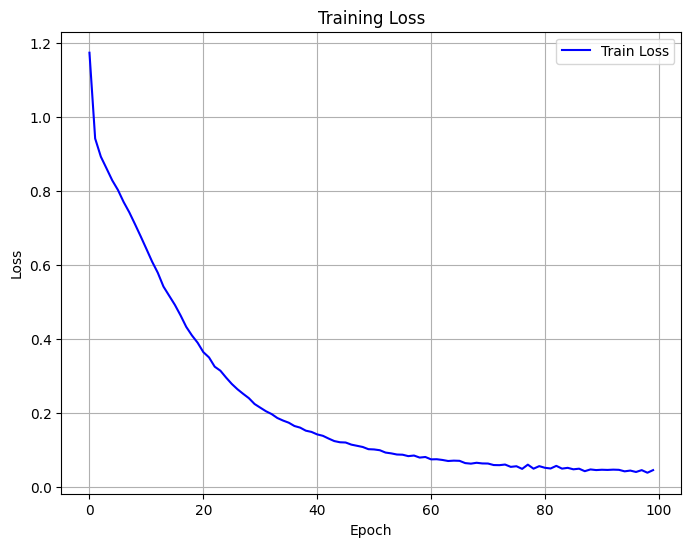

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)
plt.show()

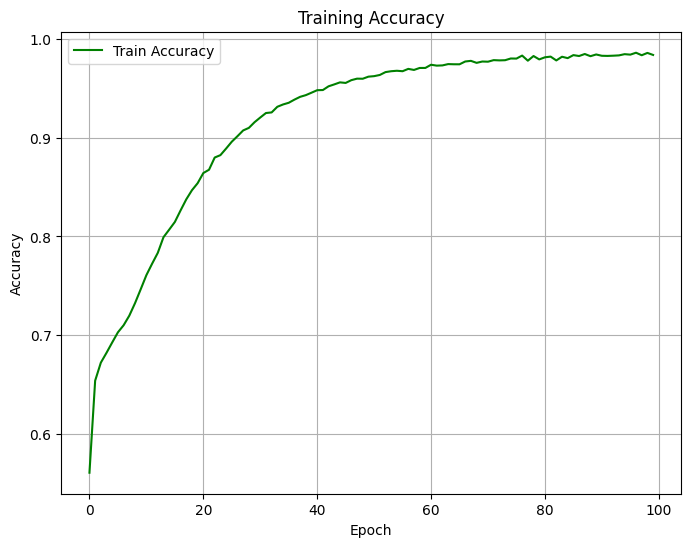

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(train_accuracies, label='Train Accuracy', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()
plt.grid(True)
plt.show()

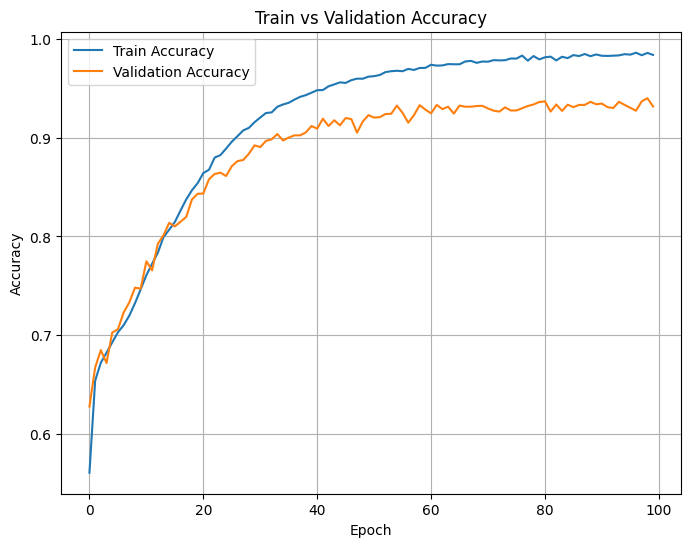

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

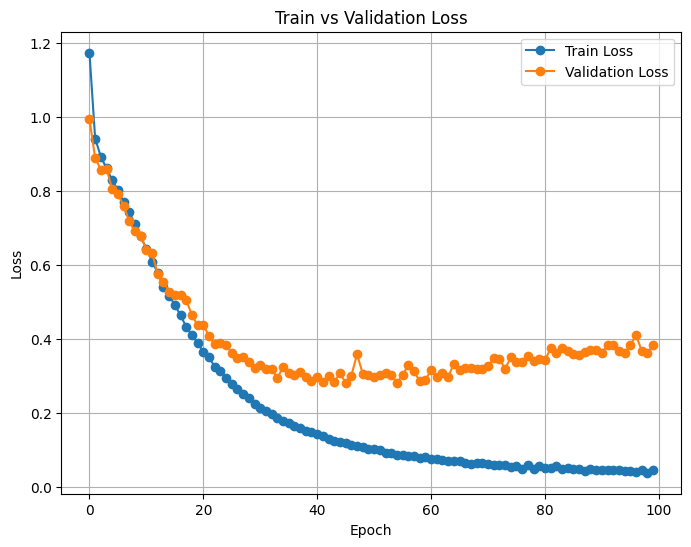

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())


print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

Classification Report:

                      precision    recall  f1-score   support

             Anxiety       0.96      0.99      0.97       635
             Bipolar       0.96      1.00      0.98       635
          Depression       0.84      0.78      0.81       636
              Normal       0.97      0.85      0.90       635
Personality disorder       0.99      1.00      0.99       636
              Stress       0.95      1.00      0.97       636
            Suicidal       0.84      0.90      0.87       635

            accuracy                           0.93      4448
           macro avg       0.93      0.93      0.93      4448
        weighted avg       0.93      0.93      0.93      4448



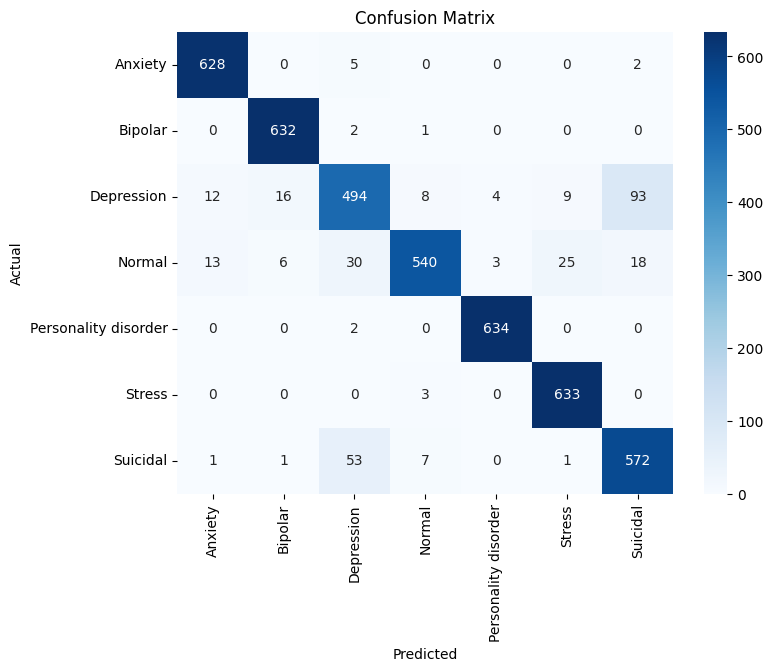

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()